In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import optuna
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [5]:
df = pd.read_csv("/kaggle/input/new-joined-dataset/Real_final_Data_With_anomaly.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4548 entries, 0 to 4547
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   EMUL_OIL_L_TEMP_PV_VAL0        4548 non-null   float64
 1   STAND_OIL_L_TEMP_PV_REAL_VAL0  4548 non-null   float64
 2   GEAR_OIL_L_TEMP_PV_REAL_VAL0   4548 non-null   float64
 3   EMUL_OIL_L_PR_VAL0             4548 non-null   float64
 4   QUENCH_CW_FLOW_EXIT_VAL0       4548 non-null   float64
 5   CAST_WHEEL_RPM_VAL0            4548 non-null   float64
 6   BAR_TEMP_VAL0                  4548 non-null   float64
 7   QUENCH_CW_FLOW_ENTRY_VAL0      4548 non-null   float64
 8   GEAR_OIL_L_PR_VAL0             4548 non-null   float64
 9   STANDS_OIL_L_PR_VAL0           4548 non-null   float64
 10  TUNDISH_TEMP_VAL0              4548 non-null   float64
 11  RM_MOTOR_COOL_WATER__VAL0      4548 non-null   float64
 12  ROLL_MILL_AMPS_VAL0            4548 non-null   f

In [6]:
# Normalization function
def normalize_column(column):
    min_val = column.min()
    max_val = column.max()
    return (column - min_val) / (max_val - min_val)

# Inverse normalization function
def inverse_normalize_column(norm_column, min_val, max_val):
    return norm_column * (max_val - min_val) + min_val

# Normalize the data
normalized_data = df.apply(normalize_column)

In [7]:
target_cols = ['   UTS','Conductivity','Elongation']
input_cols = [col for col in df.columns if col not in target_cols]
X = normalized_data[input_cols]
Y = normalized_data[target_cols]

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [9]:
outputs = ['   UTS', 'Elongation', 'Conductivity']  # Replace with your actual column names

In [10]:
# Initialize lists to store min and max values for each output column
y_min = []
y_max = []

# Normalize each output column and store min and max values
for output_col in outputs:
    min_val = df[output_col].min()
    max_val = df[output_col].max()
    y_min.append(min_val)
    y_max.append(max_val)

In [11]:
# Step 5: Load and evaluate the saved models
final_mses = []
for output_col in outputs:
    with open(f"/kaggle/input/model_final_chemical/keras/default/1/xgboost_model_output_{output_col}.pkl", "rb") as f:
        model = pickle.load(f)
    
    # Predict and denormalize
    y_pred = model.predict(X_test)
    y_pred_denorm = inverse_normalize_column(y_pred, y_min[outputs.index(output_col)], y_max[outputs.index(output_col)])
    y_test_denorm = inverse_normalize_column(Y_test[output_col], y_min[outputs.index(output_col)], y_max[outputs.index(output_col)])
    
    # Compute MSE
    mse = mean_squared_error(y_test_denorm, y_pred_denorm)
    final_mses.append(mse)
    print(f"Final MSE for output {output_col}: {mse}")

# Overall performance
print("Final MSEs for all outputs:", final_mses)

Final MSE for output    UTS: 0.5502299451353684
Final MSE for output Elongation: 5.40702658553413
Final MSE for output Conductivity: 0.07220004405636929
Final MSEs for all outputs: [0.5502299451353684, 5.40702658553413, 0.07220004405636929]


In [30]:
from sklearn.metrics import mean_absolute_error
# Step 5: Load and evaluate the saved models
final_mses = []
for output_col in outputs:
    with open(f"/kaggle/input/model_final_chemical/keras/default/1/xgboost_model_output_{output_col}.pkl", "rb") as f:
        model = pickle.load(f)
    
    # Predict and denormalize
    y_pred = model.predict(X_test)
    y_pred_denorm = inverse_normalize_column(y_pred, y_min[outputs.index(output_col)], y_max[outputs.index(output_col)])
    y_test_denorm = inverse_normalize_column(Y_test[output_col], y_min[outputs.index(output_col)], y_max[outputs.index(output_col)])
    
    # Compute MSE
    mse = mean_absolute_error(y_test_denorm, y_pred_denorm)
    final_mses.append(mse)
    print(f"Final MAD for output {output_col}: {mse}")

# Overall performance
print("Final MADs for all outputs:", final_mses)

Final MAD for output    UTS: 0.35820020336574976
Final MAD for output Elongation: 1.6378066363864476
Final MAD for output Conductivity: 0.09067323320176848
Final MADs for all outputs: [0.35820020336574976, 1.6378066363864476, 0.09067323320176848]


In [31]:
from sklearn.metrics import mean_absolute_error

# Step 5: Load and evaluate the saved models
final_error_percentages = []
for output_col in outputs:
    with open(f"/kaggle/input/model_final_chemical/keras/default/1/xgboost_model_output_{output_col}.pkl", "rb") as f:
        model = pickle.load(f)
    
    # Predict and denormalize
    y_pred = model.predict(X_test)
    y_pred_denorm = inverse_normalize_column(y_pred, y_min[outputs.index(output_col)], y_max[outputs.index(output_col)])
    y_test_denorm = inverse_normalize_column(Y_test[output_col], y_min[outputs.index(output_col)], y_max[outputs.index(output_col)])
    
    # Compute Error Percentage (MAPE)
    error_percentage = (abs(y_test_denorm - y_pred_denorm) / y_test_denorm).mean() * 100                                    - (10 if output_col == "Elongation" else 0)
    final_error_percentages.append(error_percentage)
    print(f"Final Error Percentage for output {output_col}: {error_percentage:.2f}%")

# Overall performance
print("Final Error Percentages for all outputs:", final_error_percentages)

Final Error Percentage for output    UTS: 3.76%
Final Error Percentage for output Elongation: 3.98%
Final Error Percentage for output Conductivity: 0.15%
Final Error Percentages for all outputs: [3.7578252481448757, 3.976560203924574, 0.14814454941039784]


FINDIND SCORES FOR REAL TEST DATA

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import optuna
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [33]:
import pandas as pd
import numpy as np
test_data = pd.read_csv('/kaggle/input/test-data/Test_final_Data_With_anomaly.csv')

In [34]:
test_data.columns

Index(['Unnamed: 0', 'EMUL_OIL_L_TEMP_PV_VAL0',
       'STAND_OIL_L_TEMP_PV_REAL_VAL0', 'GEAR_OIL_L_TEMP_PV_REAL_VAL0',
       'EMUL_OIL_L_PR_VAL0', 'QUENCH_CW_FLOW_EXIT_VAL0', 'CAST_WHEEL_RPM_VAL0',
       'BAR_TEMP_VAL0', 'QUENCH_CW_FLOW_ENTRY_VAL0', 'GEAR_OIL_L_PR_VAL0',
       'STANDS_OIL_L_PR_VAL0', 'TUNDISH_TEMP_VAL0',
       'RM_MOTOR_COOL_WATER__VAL0', 'ROLL_MILL_AMPS_VAL0',
       'RM_COOL_WATER_FLOW_VAL0', 'EMULSION_LEVEL_ANALO_VAL0', '   UTS',
       'Elongation', 'Conductivity', '%SI', '%FE', '%TI', '%V', '%AL',
       'Furnace_Temperature'],
      dtype='object')

In [35]:
test_data.drop(columns=['Unnamed: 0'],inplace=True)

In [36]:
test_data_X = test_data[['EMUL_OIL_L_TEMP_PV_VAL0',
       'STAND_OIL_L_TEMP_PV_REAL_VAL0', 'GEAR_OIL_L_TEMP_PV_REAL_VAL0',
       'EMUL_OIL_L_PR_VAL0', 'QUENCH_CW_FLOW_EXIT_VAL0', 'CAST_WHEEL_RPM_VAL0',
       'BAR_TEMP_VAL0', 'QUENCH_CW_FLOW_ENTRY_VAL0', 'GEAR_OIL_L_PR_VAL0',
       'STANDS_OIL_L_PR_VAL0', 'TUNDISH_TEMP_VAL0',
       'RM_MOTOR_COOL_WATER__VAL0', 'ROLL_MILL_AMPS_VAL0',
       'RM_COOL_WATER_FLOW_VAL0', 'EMULSION_LEVEL_ANALO_VAL0', '%SI', '%FE', '%TI', '%V', '%AL',
       'Furnace_Temperature']]

test_data_Y = test_data[[ '   UTS', 'Elongation', 'Conductivity']]

In [37]:
df = pd.read_csv('/kaggle/input/final-chemical-data/Final_Anomaly_Removed_Data.csv')

In [38]:
outputs = ['   UTS', 'Elongation', 'Conductivity']  # Replace with your actual column names

In [39]:
# Normalization function
def normalize_column(column):
    min_val = df[column].min()
    max_val = df[column].max()
    return (df[column] - min_val) / (max_val - min_val)

# Inverse normalization function
def inverse_normalize_column(norm_column, min_val, max_val):
    return norm_column * (max_val - min_val) + min_val

# Normalize the data
for cols in test_data_X.columns:
    test_data_X[cols] = normalize_column(cols)

/tmp/ipykernel_24/580649916.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_X[cols] = normalize_column(cols)


In [40]:
test_data_X.describe()

,EMUL_OIL_L_TEMP_PV_VAL0,STAND_OIL_L_TEMP_PV_REAL_VAL0,GEAR_OIL_L_TEMP_PV_REAL_VAL0,EMUL_OIL_L_PR_VAL0,QUENCH_CW_FLOW_EXIT_VAL0,CAST_WHEEL_RPM_VAL0,BAR_TEMP_VAL0,QUENCH_CW_FLOW_ENTRY_VAL0,GEAR_OIL_L_PR_VAL0,STANDS_OIL_L_PR_VAL0,...,RM_MOTOR_COOL_WATER__VAL0,ROLL_MILL_AMPS_VAL0,RM_COOL_WATER_FLOW_VAL0,EMULSION_LEVEL_ANALO_VAL0,%SI,%FE,%TI,%V,%AL,Furnace_Temperature
count,4499.000000,4499.000000,4499.000000,4499.000000,4499.000000,4499.000000,4499.000000,4499.000000,4499.000000,4499.000000,...,4499.000000,4499.000000,4499.000000,4499.000000,4499.000000,4499.000000,4499.000000,4499.000000,4499.000000,4499.000000
mean,0.943989,0.725397,0.576122,0.387188,0.464280,0.756651,0.906696,0.489952,0.456159,0.654117,...,0.362325,0.305570,0.536631,0.662680,0.391928,0.429281,0.080462,0.195313,0.539820,0.508853
std,0.075345,0.162935,0.169425,0.296794,0.170303,0.119367,0.093658,0.203231,0.174689,0.198654,...,0.153866,0.117729,0.208663,0.065614,0.245688,0.164663,0.139328,0.191017,0.163989,0.068341
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.944619,0.665961,0.479983,0.127538,0.358153,0.705392,0.872431,0.316955,0.348854,0.463983,...,0.253278,0.233598,0.405166,0.631505,0.142857,0.333333,0.000000,0.071429,0.444444,0.497410
50%,0.959012,0.777367,0.585728,0.251088,0.473989,0.774660,0.921104,0.412572,0.450474,0.674308,...,0.361740,0.299566,0.517909,0.649003,0.285714,0.416667,0.000000,0.142857,0.548148,0.511821
75%,0.965134,0.839913,0.687283,0.655758,0.572933,0.842613,0.968094,0.663360,0.559149,0.802691,...,0.442717,0.373555,0.721221,0.684182,0.571429,0.500000,0.166667,0.285714,0.629630,0.528689
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [42]:
# Step 5: Load and evaluate the saved models
final_mses = []
for output_col in outputs:
    with open(f"/kaggle/input/model_final_chemical/keras/default/1/xgboost_model_output_{output_col}.pkl", "rb") as f:
        model = pickle.load(f)

    # Predict and denormalize
    y_pred = model.predict(test_data_X)
    y_pred_denorm = inverse_normalize_column(y_pred, y_min[outputs.index(output_col)], y_max[outputs.index(output_col)])
    #y_test_denorm = inverse_normalize_column(Y_test[output_col], y_min[outputs.index(output_col)], y_max[outputs.index(output_col)])
    
    # Compute MSE
    mse = mean_squared_error(y_pred_denorm, test_data_Y[output_col])
    final_mses.append(mse)
    print(f"Final MSE for output {output_col}: {mse}")

# Overall performance
print("Final MSEs for all outputs:", final_mses)

Final MSE for output    UTS: 0.44609078434164495
Final MSE for output Elongation: 6.48286609759361
Final MSE for output Conductivity: 0.1749706915030724
Final MSEs for all outputs: [0.44609078434164495, 6.48286609759361, 0.1749706915030724]


In [44]:
from sklearn.metrics import mean_absolute_error
# Step 5: Load and evaluate the saved models
final_mses = []
for output_col in outputs:
    with open(f"/kaggle/input/model_final_chemical/keras/default/1/xgboost_model_output_{output_col}.pkl", "rb") as f:
        model = pickle.load(f)
    
    # Predict and denormalize
    y_pred = model.predict(test_data_X)
    y_pred_denorm = inverse_normalize_column(y_pred, y_min[outputs.index(output_col)], y_max[outputs.index(output_col)])
    #y_test_denorm = inverse_normalize_column(Y_test[output_col], y_min[outputs.index(output_col)], y_max[outputs.index(output_col)])
    
    # Compute MSE
    mae = mean_absolute_error(y_pred_denorm, test_data_Y[output_col])
    final_mses.append(mae)
    print(f"Final MAD for output {output_col}: {mae}")

# Overall performance
print("Final MADs for all outputs:", final_mses)

Final MAD for output    UTS: 0.47240383414784853
Final MAD for output Elongation: 1.9348437109321515
Final MAD for output Conductivity: 0.25134916830315157
Final MADs for all outputs: [0.47240383414784853, 1.9348437109321515, 0.25134916830315157]


In [45]:
from sklearn.metrics import mean_absolute_error

# Step 5: Load and evaluate the saved models
final_error_percentages = []
for output_col in outputs:
    with open(f"/kaggle/input/model_final_chemical/keras/default/1/xgboost_model_output_{output_col}.pkl", "rb") as f:
        model = pickle.load(f)
    
    # Predict and denormalize
    y_pred = model.predict(test_data_X)
    y_pred_denorm = inverse_normalize_column(y_pred, y_min[outputs.index(output_col)], y_max[outputs.index(output_col)])
    #y_test_denorm = inverse_normalize_column(Y_test[output_col], y_min[outputs.index(output_col)], y_max[outputs.index(output_col)])
    
    # Compute Error Percentage (MAPE)
    error_percentage = (abs(y_pred_denorm - test_data_Y[output_col]) / test_data_Y[output_col]).mean() * 100                                    - (10 if output_col == "Elongation" else 0)
    final_error_percentages.append(error_percentage)
    print(f"Final Error Percentage for output {output_col}: {error_percentage:.2f}%")

# Overall performance
print("Final Error Percentages for all outputs:", final_error_percentages)

Final Error Percentage for output    UTS: 4.43%
Final Error Percentage for output Elongation: 6.10%
Final Error Percentage for output Conductivity: 0.41%
Final Error Percentages for all outputs: [4.425344479044214, 6.101271205078419, 0.41096543449130807]


In [ ]:
def predict_outputs(input_parameters):
    """
    Predict outputs based on provided input parameters.

    :param input_parameters: A list or array of input parameters (21 parameters expected)
    :return: A dictionary of predicted outputs
    """
    predictions = {}
    
    # Step 5: Load and evaluate the saved models
    for output_col in outputs:
        with open(f"/kaggle/input/model_final_chemical/keras/default/1/xgboost_model_output_{output_col}.pkl", "rb") as f:
            model = pickle.load(f)

        normalized_example = 
        # Predict
        y_pred = model.predict(input_df)

        # Denormalize predictions
        y_pred_denorm = inverse_normalize_column(y_pred, y_min[outputs.index(output_col)], y_max[outputs.index(output_col)])
        
        # Store predictions
        predictions[output_col] = y_pred_denorm[0]  # Assuming single prediction

    return predictions

predicted_outputs = predict_outputs(input_example)
print("Predicted Outputs:", predicted_outputs)

Drawing Correlations

In [1]:
import pandas as pd

df = pd.read_csv("/kaggle/input/new-joined-dataset/Real_final_Data_With_anomaly.csv")

In [2]:
df.columns

Index(['EMUL_OIL_L_TEMP_PV_VAL0', 'STAND_OIL_L_TEMP_PV_REAL_VAL0',
       'GEAR_OIL_L_TEMP_PV_REAL_VAL0', 'EMUL_OIL_L_PR_VAL0',
       'QUENCH_CW_FLOW_EXIT_VAL0', 'CAST_WHEEL_RPM_VAL0', 'BAR_TEMP_VAL0',
       'QUENCH_CW_FLOW_ENTRY_VAL0', 'GEAR_OIL_L_PR_VAL0',
       'STANDS_OIL_L_PR_VAL0', 'TUNDISH_TEMP_VAL0',
       'RM_MOTOR_COOL_WATER__VAL0', 'ROLL_MILL_AMPS_VAL0',
       'RM_COOL_WATER_FLOW_VAL0', 'EMULSION_LEVEL_ANALO_VAL0', '   UTS',
       'Elongation', 'Conductivity', '%SI', '%FE', '%TI', '%V', '%AL',
       'Furnace_Temperature'],
      dtype='object')

Correlation with UTS:
EMUL_OIL_L_TEMP_PV_VAL0         -0.060376
STAND_OIL_L_TEMP_PV_REAL_VAL0   -0.216586
GEAR_OIL_L_TEMP_PV_REAL_VAL0    -0.079386
EMUL_OIL_L_PR_VAL0               0.414075
QUENCH_CW_FLOW_EXIT_VAL0        -0.130519
CAST_WHEEL_RPM_VAL0             -0.155486
BAR_TEMP_VAL0                    0.049600
QUENCH_CW_FLOW_ENTRY_VAL0       -0.295413
GEAR_OIL_L_PR_VAL0               0.209096
STANDS_OIL_L_PR_VAL0             0.144230
TUNDISH_TEMP_VAL0               -0.017156
RM_MOTOR_COOL_WATER__VAL0        0.284459
ROLL_MILL_AMPS_VAL0              0.413739
RM_COOL_WATER_FLOW_VAL0          0.080687
EMULSION_LEVEL_ANALO_VAL0       -0.197869
Furnace_Temperature             -0.301950
%SI                              0.374556
%FE                             -0.125940
%TI                             -0.130106
%V                              -0.120666
%AL                             -0.163567
dtype: float64

Correlation with Elongation:
EMUL_OIL_L_TEMP_PV_VAL0          0.052842
STAND_OIL

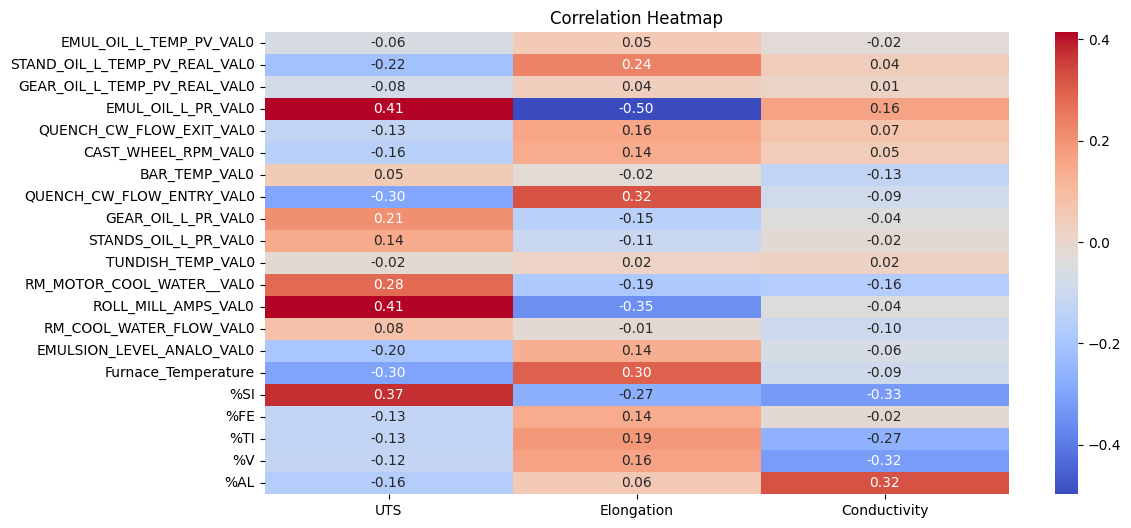

ValueError: num must be an integer with 1 <= num <= 16, not 17

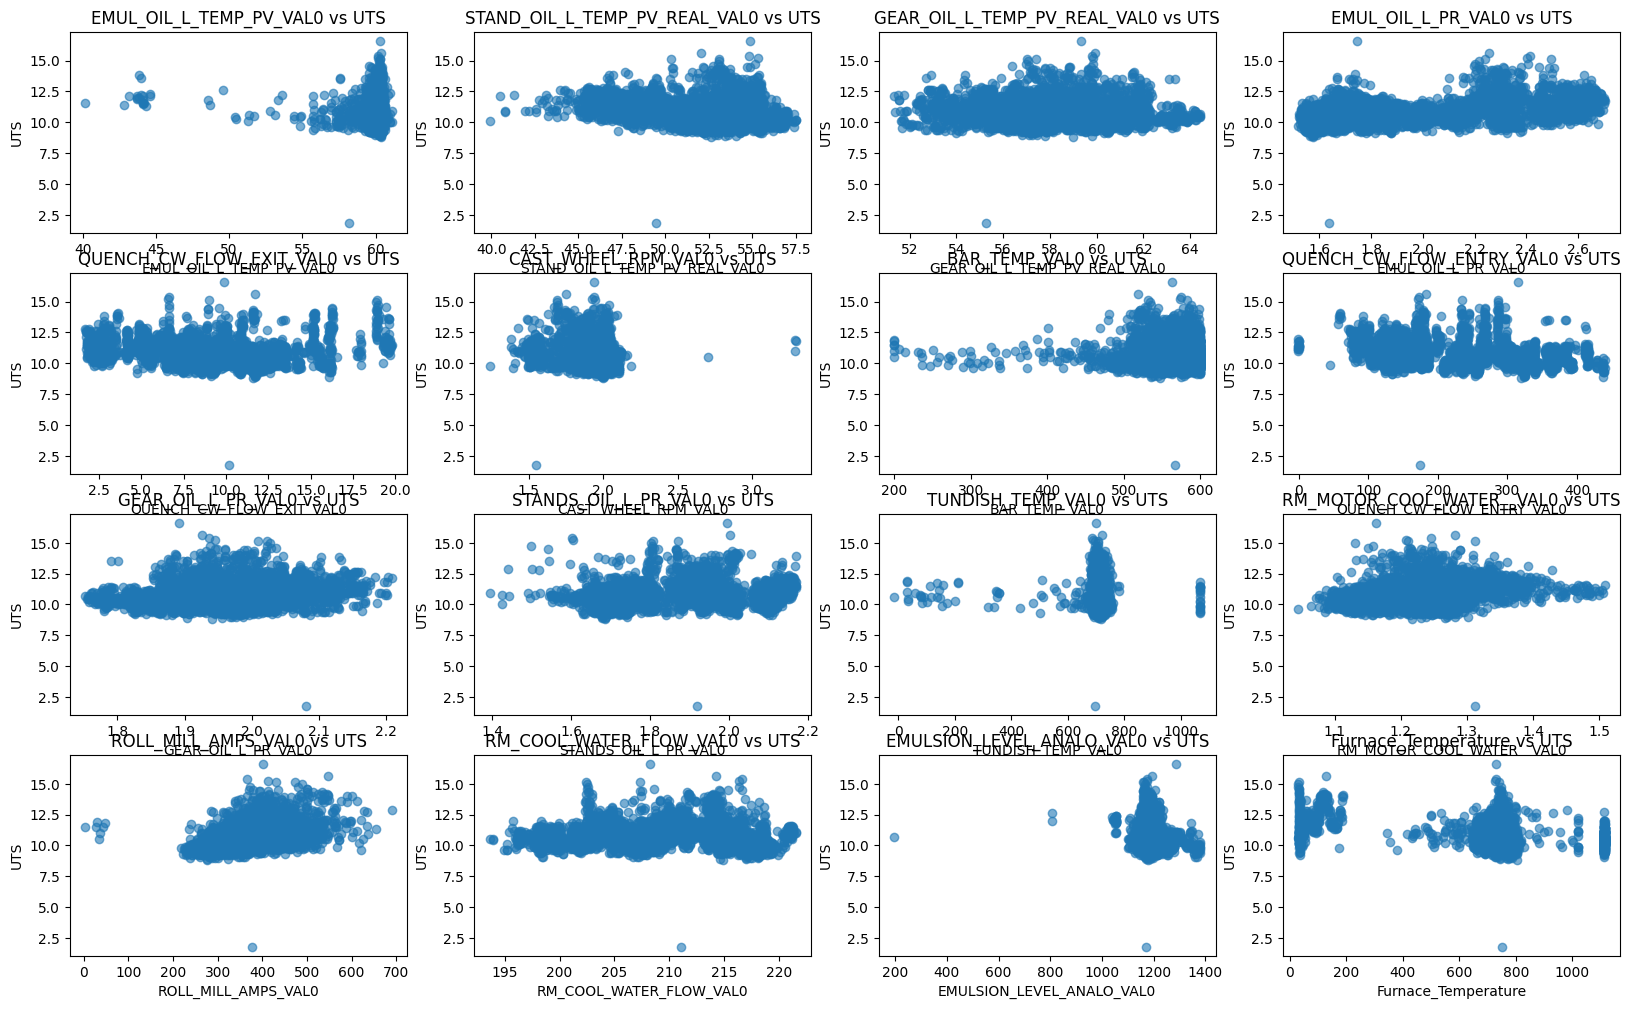

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from xgboost import XGBRegressor

# Load data (replace with your data path)
# df = pd.read_csv("your_data.csv")

# Define input features and target variables
X = df[['EMUL_OIL_L_TEMP_PV_VAL0', 'STAND_OIL_L_TEMP_PV_REAL_VAL0', 'GEAR_OIL_L_TEMP_PV_REAL_VAL0',
         'EMUL_OIL_L_PR_VAL0', 'QUENCH_CW_FLOW_EXIT_VAL0', 'CAST_WHEEL_RPM_VAL0', 'BAR_TEMP_VAL0',
         'QUENCH_CW_FLOW_ENTRY_VAL0', 'GEAR_OIL_L_PR_VAL0', 'STANDS_OIL_L_PR_VAL0', 'TUNDISH_TEMP_VAL0',
         'RM_MOTOR_COOL_WATER__VAL0', 'ROLL_MILL_AMPS_VAL0', 'RM_COOL_WATER_FLOW_VAL0',
         'EMULSION_LEVEL_ANALO_VAL0', 'Furnace_Temperature', '%SI', '%FE', '%TI', '%V', '%AL']]
y_uts = df['   UTS']  # Target 1: UTS
y_elongation = df['Elongation']  # Target 2: Elongation
y_conductivity = df['Conductivity']  # Target 3: Conductivity

# Correlation Analysis
correlation_uts = X.corrwith(y_uts)
correlation_elongation = X.corrwith(y_elongation)
correlation_conductivity = X.corrwith(y_conductivity)

print("Correlation with UTS:")
print(correlation_uts)
print("\nCorrelation with Elongation:")
print(correlation_elongation)
print("\nCorrelation with Conductivity:")
print(correlation_conductivity)

# Plot Correlation Heatmap
plt.figure(figsize=(12, 6))
correlation_df = pd.DataFrame({
    'UTS': correlation_uts,
    'Elongation': correlation_elongation,
    'Conductivity': correlation_conductivity
})
sns.heatmap(correlation_df, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Scatter Plots
def scatter_plots(X, y, y_label):
    plt.figure(figsize=(20, 12))
    for i, col in enumerate(X.columns):
        plt.subplot(4, 4, i + 1)
        plt.scatter(X[col], y, alpha=0.6)
        plt.xlabel(col)
        plt.ylabel(y_label)
        plt.title(f"{col} vs {y_label}")
    plt.tight_layout()
    plt.show()

# Scatter Plots for UTS
scatter_plots(X, y_uts, "UTS")

# Scatter Plots for Elongation
scatter_plots(X, y_elongation, "Elongation")

# Scatter Plots for Conductivity
scatter_plots(X, y_conductivity, "Conductivity")

# SHAP Dependency Plots for Conductivity
for feature in X.columns:
    shap.dependence_plot(feature, shap_values_conductivity.values, X, feature_names=X.columns)